In [30]:
import sys
sys.path.append('../')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [31]:
WYSCOUT_ID = 5414111
SKILLCORNER_ID = 952209

NETWORKS_PATH = f'../../data/networks/match_{SKILLCORNER_ID}/'
PASSES_DF_PATH = NETWORKS_PATH + 'passes_df.csv'

DATA_PATH= f'../../data/'
XT_PLOT_PATH = DATA_PATH + 'smoothed_xt.csv'
METADATA_PATH = DATA_PATH + f'skillcorner/{SKILLCORNER_ID}_metadata.csv'

In [32]:
passes_df = pd.read_csv(PASSES_DF_PATH)
xt_table = pd.read_csv(XT_PLOT_PATH)

# Utils

## ΔxT

In [33]:
pitch_length, pitch_width = pd.read_csv(METADATA_PATH)[['pitch_length', 'pitch_width']].values[0]
cell_width = pitch_length / xt_table.shape[1]
cell_height = pitch_width / xt_table.shape[0]

def adjust_coordinates(x, y, direction):
    if direction == 'TOP_TO_BOTTOM':
        x = - x + pitch_length/2
        y = -y + pitch_width/2
    elif direction == 'BOTTOM_TO_TOP':
        x = x + pitch_length/2
        y = y + pitch_width/2
    return x, y

def get_xt_index(x, y, direction):
    x_adj, y_adj = adjust_coordinates(x, y, direction)
    x_index = int(min(x_adj // cell_width, xt_table.shape[1] - 1))
    y_index = int(min(y_adj // cell_height, xt_table.shape[0] - 1))
    return x_index, y_index

def get_xt_value(x, y, direction):
    x_index, y_index = get_xt_index(x, y, direction)
    return xt_table.iat[y_index, x_index]

def get_dxt(x_start, y_start, x_end, y_end, direction):
    start_xt = get_xt_value(x_start, y_start, direction)
    end_xt = get_xt_value(x_end, y_end, direction)
    return end_xt - start_xt

## Defender Responsibility 

In [34]:
def responsibility(start_x, start_y, end_x, end_y, player_x, player_y, ball_speed=12.0, defender_speed=6.0):

    # Pass vector and length
    pass_vector = np.array([end_x - start_x, end_y - start_y])
    pass_length = np.linalg.norm(pass_vector)

    if pass_length == 0:
        return 0
    
    pass_unit_vector = pass_vector / pass_length
    player_vector = np.array([player_x - start_x, player_y - start_y])


    projection_length = np.dot(player_vector, pass_unit_vector)
    projection_length = max(0, min(projection_length, pass_length))

    perpendicular_distance = np.linalg.norm(player_vector - (projection_length * pass_unit_vector))
    triangle_width_at_point = 2 * defender_speed * (projection_length / ball_speed)

    half_width = triangle_width_at_point / 2
    if perpendicular_distance <= half_width and projection_length <= pass_length:
        responsibility_score = 1 - (perpendicular_distance / half_width)
    else:
        responsibility_score = 0

    return responsibility_score

## Plotting

In [35]:
def defender_true_location(data, frame_id, defender_id):
    data = data[data['frame'] == frame_id]
    try:
        return data[data['tracking.object_id'] == defender_id][['tracking.x', 'tracking.y']].values[0]
    except:
        print("Defender id {} not in frame {}".format(defender_id, frame_id))

def get_attacker_locations(data, frame_id, include_passer=False):
    data = data[data['frame'] == frame_id]
    data = data[data['tracking.is_teammate']]
    if not include_passer:
        data = data[~data['tracking.is_self']]
    data = data[data['tracking.object_id'] != -1]
    return data[['tracking.x', 'tracking.y']].values

def get_defender_locations(data, frame_id):
    data = data[data['frame'] == frame_id]
    data = data[~data['tracking.is_teammate'] & ~data['tracking.is_self']]
    data = data[data['tracking.object_id'] != -1]
    return data[['tracking.x', 'tracking.y']].values

In [36]:
def plot_frame(data, frame_id):
    data = data[data['frame'] == frame_id]
    data = data[data['tracking.object_id'] != -1]
    _, ax = plt.subplots()
    ax.set_xlim([-pitch_length/2, pitch_length/2])
    ax.set_ylim([-pitch_width/2, pitch_width/2])
    
    # Create a dictionary to store the labels
    labels = {'Passer': None, 'Teammate': None, 'Opponent': None}
    
    for _, player in data.iterrows():
        x, y = player['tracking.x'], player['tracking.y']
        if player['tracking.is_self']:
            color = 'green'
            marker = 'D'
            label = 'Passer'
        elif player['tracking.is_teammate']:
            color = 'blue'
            marker = 'D'
            label = 'Teammate'
        else:
            color = 'red'
            marker = 'o'
            label = 'Opponent'
        # Plot the player and store the label if not already stored
        scatter = ax.scatter(x, y, color=color, marker=marker)
        # anotate defenders only
        if not player['tracking.is_teammate']:
            ax.annotate(player['tracking.object_id'], (x, y), textcoords="offset points", xytext=(0,10), ha='center')
        if labels[label] is None:
            labels[label] = scatter
            
    # Add arrow indicating direction of play
    direction = data['play_direction'].values[0]
    if direction == 'TOP_TO_BOTTOM':
        # right to left arrow
        ax.arrow(pitch_length/2, 0, -pitch_length/32, 0, head_width=2, head_length=4, fc='k', ec='k')
    else:
        # left to right arrow
        ax.arrow(-pitch_length/2, 0, pitch_length/32, 0, head_width=2, head_length=4, fc='k', ec='k')

    # Create the legend
    ax.legend(labels.values(), labels.keys())
    plt.show()

In [37]:
def plot_players(passes_df, frame_id, defender_id=None, max_threat_receiver_id=None): 
    # Get the passer and receiver of the true pass 
    passer_id = passes_df[passes_df['frame'] == frame_id]['player.id.skillcorner'].values[0]
    passer_loc = passes_df[(passes_df['frame'] == frame_id) & (passes_df['tracking.object_id'] == passer_id)][['tracking.x', 'tracking.y']].values[0]
    receiver_id = passes_df[passes_df['frame'] == frame_id]['pass.recipient.id.skillcorner'].values[0]
    receiver_loc = passes_df[(passes_df['frame'] == frame_id) & (passes_df['tracking.object_id'] == receiver_id)][['tracking.x', 'tracking.y']].values[0]
    x_start, y_start = passer_loc
    x_end, y_end = receiver_loc

    # Plot true pass
    plt.plot([x_start, x_end], [y_start, y_end], color='black', linestyle='dashed', label='True Pass', linewidth=1)

    # Plot highest scoring pass
    if max_threat_receiver_id:
        max_threat_receiver_loc = passes_df[(passes_df['frame'] == frame_id) & (passes_df['tracking.object_id'] == max_threat_receiver_id)][['tracking.x', 'tracking.y']].values[0]
        x_best, y_best = max_threat_receiver_loc
        plt.plot([x_start, x_best], [y_start, y_best], color='gray', linestyle='dashed', label='Best Pass', linewidth=1)

    # Plot attackers
    attackers = get_attacker_locations(passes_df, frame_id, include_passer=False)
    plt.scatter(attackers[:,0], attackers[:,1], color='red', marker='D', label='Attackers')

    # Plot defenders
    defenders = get_defender_locations(passes_df, frame_id)
    plt.scatter(defenders[:,0], defenders[:,1], color='blue', label='Defenders')

    # Plot passer
    plt.scatter(*passer_loc, color='green', marker='D', label='Passer')

    # Plot target defender
    if defender_id:
        x_def, y_def = defender_true_location(passes_df, frame_id, defender_id)
        plt.scatter(x_def, y_def, color='pink', label='Target Defender')

In [38]:
def passers_expected_threat(defender_x, defender_y, defender_id, passer_loc, recipients, defenders):
    
    defenders.loc[defenders['tracking.object_id'] == defender_id, ['tracking.x', 'tracking.y']] = [defender_x, defender_y]

    expected_threat_dict = {}
    for _, recipient in recipients.iterrows():
        
        # Threat of the pass
        threat_of_pass = recipient['threat_of_pass']
        # Pass success probability
        prob_success = 1
        for _, defender in defenders.iterrows(): 
            resp_value = responsibility(*passer_loc, recipient['tracking.x'], recipient['tracking.y'], defender['tracking.x'], defender['tracking.y'])
            prob_success *= (1 - resp_value)

        # Expected threat
        expected_threat_dict[recipient['tracking.object_id']] = threat_of_pass * prob_success
        
    return expected_threat_dict

def create_opt_func(data, frame_id, defender_id):
    data = data[data['frame'] == frame_id]
    
    recipients = data[data['tracking.is_teammate'] & ~data['tracking.is_self'] & (data['tracking.object_id'] != -1)].copy()
    defenders = data[~data['tracking.is_teammate'] & ~data['tracking.is_self'] & (data['tracking.object_id'] != -1)].copy()
    
    passer_id = data['player.id.skillcorner'].values[0]
    passer_location = data[data['tracking.object_id'] == passer_id][['tracking.x', 'tracking.y']].values[0]
    
    play_direction =  data['play_direction'].values[0]
    
    threats = []
    for _, recipient in recipients.iterrows():
        recipient_location = recipient['tracking.x'], recipient['tracking.y']
        threats.append(get_dxt(*passer_location, *recipient_location, play_direction))
    recipients['threat_of_pass'] = threats
    def opt_func(x,y):
        return passers_expected_threat(x, y, defender_id, passer_location, recipients, defenders)
    return opt_func

def threat_aggregator(mode='softmax', k=3, temp=1):
    if mode == 'max':
        return lambda x: max(x.values())
    elif mode == 'softmax':
        def softmax(x):
            """
            x = np.array(list(x.values()))
            exp_x = np.exp(x/temp)
            softmax_scores = exp_x / np.sum(exp_x) 
            return sum(softmax_scores * x)"""
            x_values = np.array(list(x.values()))
            positive_values = x_values[x_values > 0]
            if len(positive_values) == 0:  # Handle case where no positive values are present
                return 0
            exp_x = np.exp(positive_values / temp)
            softmax_scores = exp_x / np.sum(exp_x)
            return sum(softmax_scores * positive_values)
        return softmax
        return lambda x: sum([np.exp(v) for v in x.values()])
    elif mode == 'topK':
        return lambda x: sum(sorted(x.values(), reverse=True)[:k])
    elif mode == 'mean':
        return lambda x: sum(x.values()) / len(x)
    elif mode == 'sum':
        return lambda x: sum(x.values())
    else:
        raise ValueError('Invalid mode')
    

# Filter events where all options have negative dxt

In [39]:
def all_neg(scores):
    for v in scores.values():
        if v > 0:
            return False
    return True

def all_negative_dxt_frames(passes_df):
    all_negative_frame = []
    pass_frames = passes_df['frame'].unique()

    for frame in pass_frames:
        #print(frame)
        opt_func = create_opt_func(passes_df, frame, -1)
        defender_location = defender_true_location(passes_df, frame, -1)
        
        x_origin, y_origin = defender_location
        
        true_scores = opt_func(x_origin, y_origin)


        if all_neg(true_scores):
            all_negative_frame.append(frame)

    return all_negative_frame


In [40]:
negative_frames = all_negative_dxt_frames(passes_df)

# Filter passes_df to exclude these frames
passes_df = passes_df[~passes_df['frame'].isin(negative_frames)]

# Visualize Player Locations

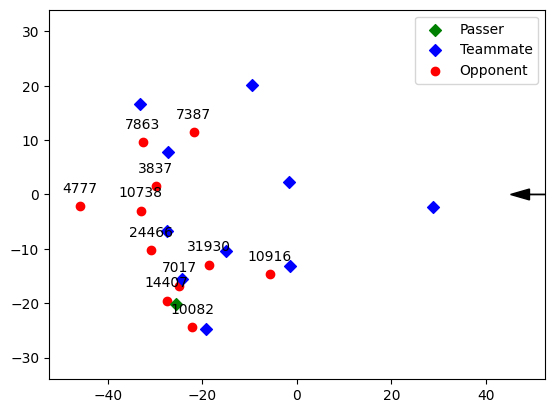

In [41]:
#frame_id = np.random.choice(passes_df['frame'].unique())
frame_id = 31945
plot_frame(passes_df, frame_id)

# Defender Position Score Visualization

In [42]:
"""
frame_id = 48981
defender_id = 12246

if frame_id not in passes_df['frame'].unique():
    print('This passer does not have any options that would generate a positive threat')

opt_func = create_opt_func(passes_df, frame_id, defender_id)
threat_agg = threat_aggregator('mean')

# Get target defender's true location
x_def, y_def = defender_true_location(passes_df, frame_id, defender_id)

# Get achieved score of the target defender
true_scores = opt_func(x_def, y_def)
true_score = threat_agg(true_scores)
max_threat_receiver_id = max(true_scores, key=true_scores.get)

# Create a meshgrid around the origin point
x = np.linspace(max(x_def - 20, -pitch_length/2), min(x_def + 20, pitch_length/2), 30)
y = np.linspace(max(x_def -20, -pitch_width/2), min(y_def + 20, pitch_length/2), 30)
X, Y = np.meshgrid(x, y)

# Evaluate the function on the grid
Z = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i, j] = -threat_agg((opt_func(X[i,j],Y[i,j])))

# Plot the function
plt.figure(figsize=(10, 6))
plt.contourf(X, Y, Z, levels=50, cmap='viridis')
plt.colorbar(label='Function Value')

plot_players(passes_df, frame_id, defender_id, max_threat_receiver_id)

plt.legend()
plt.title('Score of Target Defender (Average of Attacker Options)')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.xlim([-pitch_length/2, pitch_length/2])
plt.ylim([-pitch_width/2, pitch_width/2])
plt.show()"""

"\nframe_id = 48981\ndefender_id = 12246\n\nif frame_id not in passes_df['frame'].unique():\n    print('This passer does not have any options that would generate a positive threat')\n\nopt_func = create_opt_func(passes_df, frame_id, defender_id)\nthreat_agg = threat_aggregator('mean')\n\n# Get target defender's true location\nx_def, y_def = defender_true_location(passes_df, frame_id, defender_id)\n\n# Get achieved score of the target defender\ntrue_scores = opt_func(x_def, y_def)\ntrue_score = threat_agg(true_scores)\nmax_threat_receiver_id = max(true_scores, key=true_scores.get)\n\n# Create a meshgrid around the origin point\nx = np.linspace(max(x_def - 20, -pitch_length/2), min(x_def + 20, pitch_length/2), 30)\ny = np.linspace(max(x_def -20, -pitch_width/2), min(y_def + 20, pitch_length/2), 30)\nX, Y = np.meshgrid(x, y)\n\n# Evaluate the function on the grid\nZ = np.zeros_like(X)\nfor i in range(X.shape[0]):\n    for j in range(X.shape[1]):\n        Z[i, j] = -threat_agg((opt_func(X[

In [43]:
for id in passes_df[(passes_df['frame'] == 10664) & (~passes_df['tracking.is_teammate']) & (passes_df['tracking.object_id'] != -1)]['tracking.object_id'].values:
    print(id)

7604
16320
11516
11630
11606
12218
277
946
5922
6028
12190


Maximum threat: -0.0006817727823866902
Optimal location: (-30.328275862068967, -6.103448275862068)
True threat: -0.0019569955366422927
True location: (-33.04, -3.0)
Improvement: 0.0012752227542556023
Improvement percentage:	 65.162272%


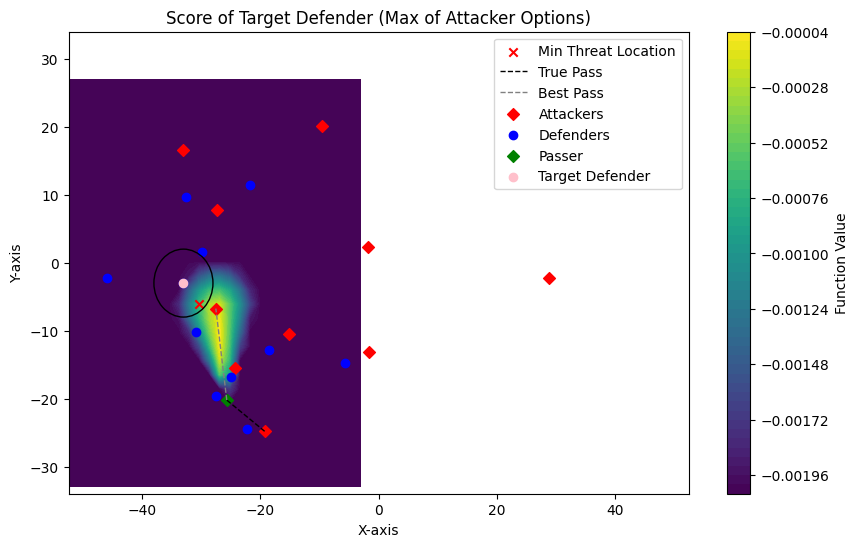

In [44]:
frame_id = 31945
defender_id = 10738

opt_func = create_opt_func(passes_df, frame_id, defender_id)
threat_agg = threat_aggregator('softmax', temp=0.005)
#threat_agg = threat_aggregator('max')

# Get target defender's true location
x_def, y_def = defender_true_location(passes_df, frame_id, defender_id)


# Get achieved score of the target defender
true_scores = opt_func(x_def, y_def)
true_score = -threat_agg(true_scores)
max_threat_receiver_id = max(true_scores, key=true_scores.get)

grid = 30
# Create a meshgrid around the origin point
x = np.linspace(max(x_def - grid, -pitch_length/2), min(x_def + grid, pitch_length/2), 30)
y = np.linspace(max(y_def - grid, -pitch_width/2), min(y_def + grid, pitch_width/2), 30)
X, Y = np.meshgrid(x, y)



# Evaluate the function on the grid
Z = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i, j] = -threat_agg((opt_func(X[i,j],Y[i,j])))

M = 50000
max_Z = true_score
x, y = x_def, y_def
radius = 5  # 5 meters radius
for i in range(Z.shape[0]):
    for j in range(Z.shape[1]):
        # Calculate the distance to the defender's original location
        distance = np.sqrt((X[i, j] - x_def)**2 + (Y[i, j] - y_def)**2)
        # Consider only points within the specified radius
        if distance <= radius and Z[i, j] > max_Z: # distance filtresinde sıkıntı çıkabiliyor
            max_Z = Z[i, j]
            x, y = X[i, j], Y[i, j]

            
print(f'Maximum threat: {max_Z}')
print(f'Optimal location: ({x}, {y})')
print(f'True threat: {true_score}')
print(f'True location: ({x_def}, {y_def})')
print(f'Improvement: {max_Z - true_score}')
print(f'Improvement percentage:\t {100 * (max_Z - true_score) / abs(true_score):.6f}%')

            
# Plot the function
plt.figure(figsize=(10, 6))
plt.contourf(X, Y, Z, levels=50, cmap='viridis')
plt.colorbar(label='Function Value')

plt.scatter(x, y, color='red', marker='x', label='Min Threat Location')

plot_players(passes_df, frame_id, defender_id, max_threat_receiver_id)
circle = plt.Circle((x_def, y_def), radius, color='black', fill=False)
plt.gca().add_artist(circle)
plt.legend()
plt.title('Score of Target Defender (Max of Attacker Options)')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.xlim([-pitch_length/2, pitch_length/2])
plt.ylim([-pitch_width/2, pitch_width/2])
plt.show()

In [45]:
true_scores, true_score

({7604: np.float64(-0.0032807400501227726),
  16320: np.float64(-0.002341459276600279),
  11516: np.float64(-0.0009534014699390852),
  11630: np.float64(-0.002964270315539235),
  11606: np.float64(-0.007078062611814399),
  12218: np.float64(-0.0016146812752158327),
  277: np.float64(-0.00022100895167125433),
  946: np.float64(0.00011034872785109493),
  5922: np.float64(2.8330199735471877e-06),
  12190: np.float64(0.0037664107091191683)},
 np.float64(-0.0019569955366422927))

In [46]:
"""
frame_id = 48981
defender_id = 12246

opt_func = create_opt_func(passes_df, frame_id, defender_id)
threat_agg = threat_aggregator('max')

# Get target defender's true location
x_def, y_def = defender_true_location(passes_df, frame_id, defender_id)

# Get achieved score of the target defender
true_scores = opt_func(x_def, y_def)
true_score = threat_agg(true_scores)
max_threat_receiver_id = max(true_scores, key=true_scores.get)

# Create a meshgrid around the origin point
x = np.linspace(max(x_def - 20, -pitch_length/2), min(x_def + 20, pitch_length/2), 30)
y = np.linspace(max(y_def -20, -pitch_width/2), min(y_def + 20, pitch_width/2), 30)
X, Y = np.meshgrid(x, y)

# Evaluate the function on the grid
Z = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i, j] = -threat_agg((opt_func(X[i,j],Y[i,j]))) # defender aims to maximize negative of best threat

# Plot the function
plt.figure(figsize=(10, 6))
plt.contourf(X, Y, Z, levels=50, cmap='viridis')
plt.colorbar(label='Function Value')

plot_players(passes_df, frame_id, defender_id, max_threat_receiver_id)

plt.legend()
plt.title('Score of Target Defender (Max of Attacker Options)')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.xlim([-pitch_length/2, pitch_length/2])
plt.ylim([-pitch_width/2, pitch_width/2])
plt.show()"""

"\nframe_id = 48981\ndefender_id = 12246\n\nopt_func = create_opt_func(passes_df, frame_id, defender_id)\nthreat_agg = threat_aggregator('max')\n\n# Get target defender's true location\nx_def, y_def = defender_true_location(passes_df, frame_id, defender_id)\n\n# Get achieved score of the target defender\ntrue_scores = opt_func(x_def, y_def)\ntrue_score = threat_agg(true_scores)\nmax_threat_receiver_id = max(true_scores, key=true_scores.get)\n\n# Create a meshgrid around the origin point\nx = np.linspace(max(x_def - 20, -pitch_length/2), min(x_def + 20, pitch_length/2), 30)\ny = np.linspace(max(y_def -20, -pitch_width/2), min(y_def + 20, pitch_width/2), 30)\nX, Y = np.meshgrid(x, y)\n\n# Evaluate the function on the grid\nZ = np.zeros_like(X)\nfor i in range(X.shape[0]):\n    for j in range(X.shape[1]):\n        Z[i, j] = -threat_agg((opt_func(X[i,j],Y[i,j]))) # defender aims to maximize negative of best threat\n\n# Plot the function\nplt.figure(figsize=(10, 6))\nplt.contourf(X, Y, Z, l

In [47]:
"""
frame_id = 48981
defender_id = 12246

opt_func = create_opt_func(passes_df, frame_id, defender_id)
threat_agg = threat_aggregator('topK', k=3)

# Get target defender's true location
x_def, y_def = defender_true_location(passes_df, frame_id, defender_id)

# Get achieved score of the target defender
true_scores = opt_func(x_def, y_def)
true_score = threat_agg(true_scores)
max_threat_receiver_id = max(true_scores, key=true_scores.get)

# Create a meshgrid around the origin point
x = np.linspace(max(x_def - 20, -pitch_length/2), min(x_def + 20, pitch_length/2), 30)
y = np.linspace(max(x_def -20, -pitch_width/2), min(y_def + 20, pitch_length/2), 30)
X, Y = np.meshgrid(x, y)

# Evaluate the function on the grid
Z = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i, j] = -threat_agg((opt_func(X[i,j],Y[i,j])))

# Plot the function
plt.figure(figsize=(10, 6))
plt.contourf(X, Y, Z, levels=50, cmap='viridis')
plt.colorbar(label='Function Value')

plot_players(passes_df, frame_id, defender_id, max_threat_receiver_id)

plt.legend()
plt.title('Score of Target Defender (Average of topK=3 Attacker Options)')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.xlim([-pitch_length/2, pitch_length/2])
plt.ylim([-pitch_width/2, pitch_width/2])
plt.show()"""

"\nframe_id = 48981\ndefender_id = 12246\n\nopt_func = create_opt_func(passes_df, frame_id, defender_id)\nthreat_agg = threat_aggregator('topK', k=3)\n\n# Get target defender's true location\nx_def, y_def = defender_true_location(passes_df, frame_id, defender_id)\n\n# Get achieved score of the target defender\ntrue_scores = opt_func(x_def, y_def)\ntrue_score = threat_agg(true_scores)\nmax_threat_receiver_id = max(true_scores, key=true_scores.get)\n\n# Create a meshgrid around the origin point\nx = np.linspace(max(x_def - 20, -pitch_length/2), min(x_def + 20, pitch_length/2), 30)\ny = np.linspace(max(x_def -20, -pitch_width/2), min(y_def + 20, pitch_length/2), 30)\nX, Y = np.meshgrid(x, y)\n\n# Evaluate the function on the grid\nZ = np.zeros_like(X)\nfor i in range(X.shape[0]):\n    for j in range(X.shape[1]):\n        Z[i, j] = -threat_agg((opt_func(X[i,j],Y[i,j])))\n\n# Plot the function\nplt.figure(figsize=(10, 6))\nplt.contourf(X, Y, Z, levels=50, cmap='viridis')\nplt.colorbar(label

# Best Passing Option

/var/folders/z9/z6djmqsd5m1bqhh3jv9ccpz40000gn/T/ipykernel_7783/688180948.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis', num_labels)


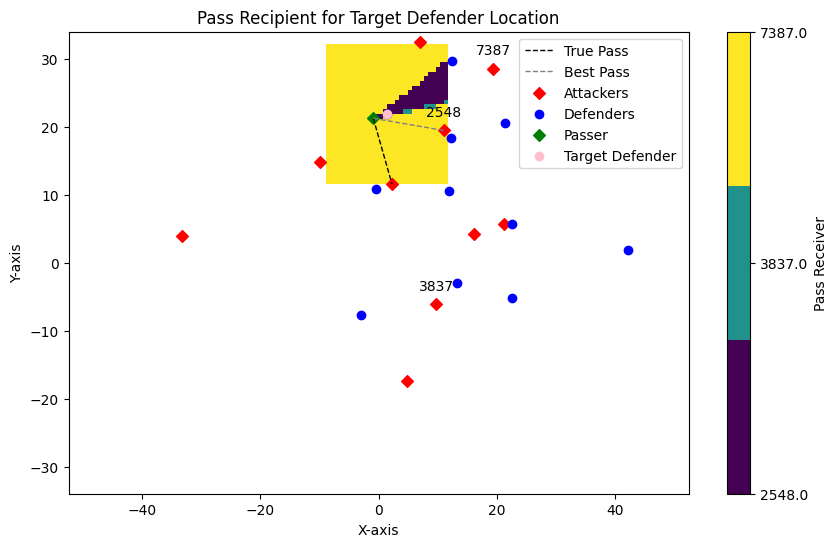

In [48]:
frame_id = 48981
defender_id = 12246

opt_func = create_opt_func(passes_df, frame_id, defender_id)
threat_agg = threat_aggregator('softmax')

# Get target defender's true location
x_def, y_def = defender_true_location(passes_df, frame_id, defender_id)

# Get achieved score of the target defender
true_scores = opt_func(x_def, y_def)
true_score = threat_agg(true_scores)
max_threat_receiver_id = max(true_scores, key=true_scores.get)

# Create a meshgrid around the origin point
x = np.linspace(max(x_def - 10, -pitch_length/2), min(x_def + 10, pitch_length/2), 30)
y = np.linspace(max(y_def -10, -pitch_width/2), min(y_def + 10, pitch_width/2), 30)
X, Y = np.meshgrid(x, y)

# Evaluate the function on the grid
Z = np.zeros_like(X)
P = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        true_scores = opt_func(X[i,j],Y[i,j])
        Z[i, j] = -max(true_scores.values())
        P[i, j] = max(true_scores, key=true_scores.get)  

# Create pass receiver colormap
unique_labels = np.unique(P)
num_labels = len(unique_labels)
label_to_class = {label: idx for idx, label in enumerate(unique_labels)}
class_to_label = {idx: label for idx, label in enumerate(unique_labels)}
P_class = np.vectorize(label_to_class.get)(P)
cmap = plt.cm.get_cmap('viridis', num_labels)

plt.figure(figsize=(10, 6))
mesh = plt.pcolormesh(X, Y, P_class, cmap=cmap, shading='auto')
cbar = plt.colorbar(mesh, ticks=np.arange(num_labels))
cbar.ax.set_yticklabels([str(class_to_label[i]) for i in range(num_labels)])
cbar.set_label('Pass Receiver')

plot_players(passes_df, frame_id, defender_id, max_threat_receiver_id)

ax = plt.gca()
for label in unique_labels:
    x, y = passes_df[(passes_df['frame'] == frame_id) & (passes_df['tracking.object_id'] == label)][['tracking.x', 'tracking.y']].values[0]
    ax.annotate(int(label), (x, y), textcoords="offset points", xytext=(0,10), ha='center')

plt.legend()
plt.title('Pass Recipient for Target Defender Location')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.xlim([-pitch_length/2, pitch_length/2])
plt.ylim([-pitch_width/2, pitch_width/2])
plt.show()

In [49]:
true_scores

{4777: -0.0057369760075819,
 24466: np.float64(0.0013654550985425795),
 10738: -0.002334402019091,
 14407: np.float64(0.0002545305105208454),
 7863: np.float64(0.0009993223058048521),
 3837: np.float64(0.0015574561862985916),
 2548: np.float64(0.0021360321908396864),
 12654: np.float64(0.0010429369087280723),
 7387: np.float64(0.0031681171793598154),
 10916: np.float64(0.00022590674640583165)}

In [50]:
def optimize_defender_location(opt_func, threat_agg, x_def, y_def, radius=3, grid_res=30):
    
    x = np.linspace(max(x_def - radius, -pitch_length/2), min(x_def + radius, pitch_length/2), grid_res)
    y = np.linspace(max(y_def - radius, -pitch_width/2), min(y_def + radius, pitch_width/2), grid_res)
    X, Y = np.meshgrid(x, y)

    Z = np.zeros_like(X)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Z[i, j] = -threat_agg((opt_func(X[i,j],Y[i,j])))
    
    Z_def = -threat_agg(opt_func(x_def, y_def))
    Z_opt = Z_def
    x_opt, y_opt = x_def, y_def
    for i in range(Z.shape[0]):
        for j in range(Z.shape[1]):
            distance = np.sqrt((X[i, j] - x_def)**2 + (Y[i, j] - y_def)**2)
            if distance <= radius and Z[i, j] > Z_opt:
                Z_opt = Z[i, j]
                x_opt, y_opt = X[i, j], Y[i, j]
    
    return Z_opt, x_opt, y_opt

## Minimax Optimization

In [51]:
# generate random frame
frame_id = np.random.choice(passes_df['frame'].unique())
frame_id

np.int64(19730)

In [52]:
# apply minimax optimization to each defender sequentially
def minimax_defender_optimization(passes_df, frame_id, radius = 5, grid_res = 20, mode = 'softmax', temp = 0.005):
    optimal_loc = dict()
    defender_locations = []
    count = 0

    # id's of opponent defenders in the pitch, excluding the goalkeeper
    defenders = passes_df[(passes_df['frame'] == frame_id) & (~passes_df['tracking.is_teammate']) & (~passes_df['tracking.object_id'].isin([-1, 7604, 4777]))]['tracking.object_id'].values
    # apply optimization to each defender
    for defender_id in defenders:
        opt_func = create_opt_func(passes_df, frame_id, defender_id)
        threat_agg = threat_aggregator(mode=mode, temp=temp)

        x_def, y_def = defender_true_location(passes_df, frame_id, defender_id) # defender loc
        Z_def = -threat_agg(opt_func(x_def, y_def))

        # optimal_locations
        Z_opt, x_opt, y_opt = optimize_defender_location(opt_func, threat_agg, x_def, y_def, radius=radius, grid_res=grid_res)

        if count == 0:
            initial_threat = Z_def
        elif count == len(defenders) - 1:
            final_threat = Z_opt

        count += 1
        # add relevant data for storing
        defender_locations.append((defender_id, x_def, y_def, x_opt, y_opt, 100 * (Z_opt - Z_def) / abs(Z_def)))
        optimal_loc[frame_id] = defender_locations

        """
        print(f'Optimal Defender Score:\t{Z_opt:.6f}')
        print(f'Original Defender Score:{Z_def:.6f}')
        print(f'Improvement:\t\t{Z_opt - Z_def:.6f}')
        print(f'Improvement Percentage:\t{100 * (Z_opt - Z_def) / abs(Z_def):.6f}%')
        print(f'Location:\t\t({x_opt:.6f}, {y_opt:.6f})')
        print(f'Original location:\t({x_def:.6f}, {y_def:.6f})')"""

        
        # update location of the iterated defender for the next steps
        passes_df['tracking.x'][(passes_df['tracking.object_id'] == defender_id) & (passes_df['frame'] == frame_id)] = x_opt
        passes_df['tracking.y'][(passes_df['tracking.object_id'] == defender_id) & (passes_df['frame'] == frame_id)] = y_opt

    return optimal_loc, - initial_threat, - final_threat

In [62]:
def create_minimax_dataframe(passes_df):
    results_list = []
    for frame_id in passes_df['frame'].unique()[:5]:
        optimal_loc, init_threat, final_threat = minimax_defender_optimization(passes_df, frame_id)

        frame_results = [
            {
                "frame_id": frame_id,
                "defender_id": d[0],
                "original_x": d[1],
                "original_y": d[2],
                "minimax_optimal_x": d[3],
                "minimax_optimal_y": d[4],
                "initial_threat": init_threat,
                "final_threat": final_threat,
            }
            for details in optimal_loc.values()
            for d in details
        ]
        

        results_list.extend(frame_results)

    minimax_results = pd.DataFrame(results_list)
    return minimax_results

In [63]:
#optimal_loc, init_threat, final_threat = minimax_defender_optimization(passes_df, frame_id)
minimax_df = create_minimax_dataframe(passes_df)

/var/folders/z9/z6djmqsd5m1bqhh3jv9ccpz40000gn/T/ipykernel_7783/193063249.py:40: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  passes_df['tracking.x'][(passes_df['tracking.object_id'] == defender_id) & (passes_df['frame'] == frame_id)] = x_o

KeyboardInterrupt: 

In [54]:
final_threat / init_threat

np.float64(0.0061640167859399)

In [55]:
minimax_results = pd.DataFrame(
    [
        {"frame_id": frame_id, "defender_id": d[0], "original_x": d[1], "original_y": d[2], "minimax_optimal_x": d[3], "minimax_optimal_y": d[4]}
        for frame_id, details in optimal_loc.items()
        for d in details
    ]
)
minimax_results['initial_threat'] = init_threat
minimax_results['final_threat'] = final_threat
minimax_results

,frame_id,defender_id,original_x,original_y,minimax_optimal_x,minimax_optimal_y,initial_threat,final_threat
0,19730,24466,5.80,13.80,1.326316,14.063158,0.00032,0.000002
1,19730,10738,3.99,0.81,0.568947,4.231053,0.00032,0.000002
2,19730,14407,-0.63,19.03,-4.051053,15.608947,0.00032,0.000002
3,19730,7863,2.42,-16.95,-2.053684,-16.160526,0.00032,0.000002
4,19730,3837,-4.96,0.29,-9.433684,-1.552105,0.00032,0.000002
5,19730,7017,-15.74,19.35,-18.634737,20.139474,0.00032,0.000002
6,19730,31930,-23.52,11.67,-26.941053,12.985789,0.00032,0.000002
7,19730,10082,-19.47,30.64,-21.838421,26.520000,0.00032,0.000002
8,19730,7387,-26.69,-8.34,-22.216316,-6.497895,0.00032,0.000002
9,19730,10916,-29.46,22.73,-25.512632,19.835263,0.00032,0.000002


In [37]:
frame_id = 10664
defender_id = 16320

radius = 5
grid_res = 20

mode = 'softmax'
temp = 0.005


opt_func = create_opt_func(passes_df, frame_id, defender_id)
threat_agg = threat_aggregator(mode=mode, temp=temp)

x_def, y_def = defender_true_location(passes_df, frame_id, defender_id)
Z_def = -threat_agg(opt_func(x_def, y_def))

Z_opt, x_opt, y_opt = optimize_defender_location(opt_func, threat_agg, x_def, y_def, radius=radius, grid_res=grid_res)

print(f'Optimal Defender Score:\t{Z_opt:.6f}')
print(f'Original Defender Score:{Z_def:.6f}')
print(f'Improvement:\t\t{Z_opt - Z_def:.6f}')
print(f'Improvement Percentage:\t{100 * (Z_opt - Z_def) / abs(Z_def):.6f}%')
print(f'Location:\t\t({x_opt:.6f}, {y_opt:.6f})')
print(f'Original location:\t({x_def:.6f}, {y_def:.6f})')

Optimal Defender Score:	-0.000080
Original Defender Score:-0.003566
Improvement:		0.003486
Improvement Percentage:	97.751594%
Location:		(-43.714211, -10.445263)
Original location:	(-45.030000, -13.340000)


## Function to return average performance of defender

In [75]:
def average_percentage_improvement_of_location(defender_id, passes_df, radius = 5, grid_res = 20, mode = 'softmax', temp = 0.005):
    
    percentage_improvements = []
    for frame_id in passes_df['frame'].unique():
        frame_df = passes_df[passes_df['frame'] == frame_id]
        if (defender_id in frame_df['tracking.object_id'].values and not frame_df.loc[frame_df['tracking.object_id'] == defender_id, 'tracking.is_teammate'].values[0]):
            opt_func = create_opt_func(passes_df, frame_id, defender_id)
            threat_agg = threat_aggregator(mode=mode, temp=temp)

            x_def, y_def = defender_true_location(passes_df, frame_id, defender_id)
            Z_def = -threat_agg(opt_func(x_def, y_def))

            Z_opt, x_opt, y_opt = optimize_defender_location(opt_func, threat_agg, x_def, y_def, radius=radius, grid_res=grid_res)

            improvement = Z_opt - Z_def
            improvement_percentage = 100 * improvement / abs(Z_def)

            if improvement_percentage > 0:
                percentage_improvements.append(improvement_percentage)
                """
                print(f'Optimal Defender Score:\t{Z_opt:.6f}')
                print(f'Original Defender Score:{Z_def:.6f}')
                print(f'Improvement:\t\t{improvement:.6f}')
                print(f'Improvement Percentage:\t{improvement_percentage:.6f}%')
                print(f'Location:\t\t({x_opt:.6f}, {y_opt:.6f})')
                print(f'Original location:\t({x_def:.6f}, {y_def:.6f})')"""
    average_positive_improvement = sum(percentage_improvements) / len(percentage_improvements)

    return average_positive_improvement, len(percentage_improvements)



In [ ]:
avg_improvement, number_involved_passes = average_percentage_improvement_of_location(defender_id, passes_df)
avg_improvement, number_involved_passes

(np.float64(16.571470553097694), 342)

In [ ]:
print("Average potential improvement in decreasing attack threat: %", round(avg_improvement, 2))
print(f"Number of passes where defender {defender_id} is involved is {number_involved_passes}")

Average potential improvement in decreasing attack threat: % 16.57
Number of passes where defender 7863 is involved is 342
